<a href="https://colab.research.google.com/github/zlximon/Tensorflow_DL/blob/master/transfer_learning_part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


--2022-05-27 18:26:49--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-05-27 18:26:49 (59.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir
#helper function

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 

unzip_data("101_food_classes_10_percent.zip")

train_dir="101_food_classes_10_percent/train/"
test_dir="101_food_classes_10_percent/test/"

--2022-05-27 18:26:52--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.98.128, 74.125.197.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.98.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   260MB/s    in 6.1s    

2022-05-27 18:26:58 (255 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [4]:
import tensorflow as tf


In [5]:
IMG_size=(224,224)
train_data_all_10p=tf.keras.preprocessing.image_dataset_from_directory(train_dir,label_mode="categorical",image_size=IMG_size)
test_data=tf.keras.preprocessing.image_dataset_from_directory(test_dir,label_mode="categorical",image_size=IMG_size,shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


model outline
1- create a modelcheck point
2- data augmentation
3- create a base model with efficienNetB0

In [6]:
checkpoint_path="101_classes_10_percent_data_model_checkpoint"
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(checkpoint_path,save_weights_only=True,monitor="val_acuuracy",save_best_only=True)

In [7]:
from tensorflow.keras import layers 
from tensorflow.keras.layers.experimental import preprocessing


In [8]:
data_augmentation=tf.keras.models.Sequential([
preprocessing.RandomFlip("horizontal"),
preprocessing.RandomRotation(0.2),
preprocessing.RandomHeight(0.2),
preprocessing.RandomWidth(0.2),
preprocessing.RandomZoom(0.2),
# preprocessing.Rescaling(1/255.) for rescaling
],name="data_augmentation")

In [9]:
#base model
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False
inputs=layers.Input(shape=(224,224,3),name="input_layer")
x=data_augmentation(inputs)
x=base_model(x,training=False)
x= layers.GlobalAveragePooling2D(name="global_avg_pool2D")(x)
outputs=layers.Dense(len(train_data_all_10p.class_names),activation="softmax",name="output_layer")(x)
model=tf.keras.Model(inputs,outputs)


16719872/16705208 [==============================] - 0s 0us/step


In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool2D (GlobalAv  (None, 1280)             0         
 eragePooling2D)                                                 
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [11]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])

In [12]:
history_all=model.fit(train_data_all_10p,epochs=5,validation_data=test_data,validation_steps=(0.15*len(test_data)),callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 90s 307ms/step - loss: 3.4703 - accuracy: 0.2457 - val_loss: 2.7670 - val_accuracy: 0.3603
Epoch 2/5
237/237 [==============================] - 59s 246ms/step - loss: 2.3613 - accuracy: 0.4574 - val_loss: 2.3338 - val_accuracy: 0.4202
Epoch 3/5
237/237 [==============================] - 53s 223ms/step - loss: 1.9869 - accuracy: 0.5258 - val_loss: 2.1540 - val_accuracy: 0.4525
Epoch 4/5
237/237 [==============================] - 47s 196ms/step - loss: 1.7552 - accuracy: 0.5714 - val_loss: 2.0130 - val_accuracy: 0.4832
Epoch 5/5
237/237 [==============================] - 46s 194ms/step - loss: 1.6044 - accuracy: 0.6083 - val_loss: 1.9878 - val_accuracy: 0.4803


In [13]:
feature_result=model.evaluate(test_data)

790/790 [==============================] - 56s 71ms/step - loss: 1.7280 - accuracy: 0.5506


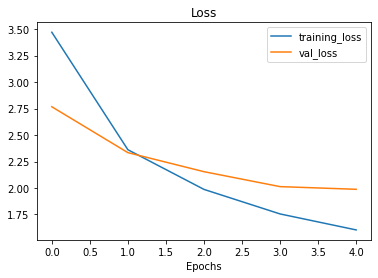

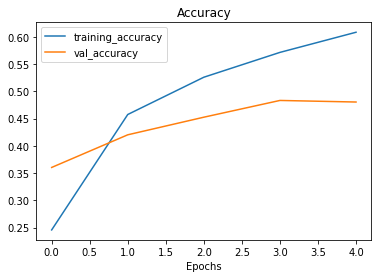

In [14]:
plot_loss_curves(history_all)

#fine tuning

In [15]:
#unfreeze all the layers
base_model.trainable=True
#refreeze every layers expect 5 last layers
for layer in base_model.layers[:-5]:
  layer.trainable=False;

In [16]:
fine_tune_epochs = 10

In [17]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,optimizer=tf.keras.optimizers.Adam(0.0001),metrics=["accuracy"])

In [18]:
history_fine=model.fit(train_data_all_10p,epochs=fine_tune_epochs,validation_data=test_data,validation_steps=(0.15*len(test_data)),initial_epoch=history_all.epoch[-1])

Epoch 5/10
237/237 [==============================] - 53s 194ms/step - loss: 1.3625 - accuracy: 0.6455 - val_loss: 1.9916 - val_accuracy: 0.4777
Epoch 6/10
237/237 [==============================] - 45s 190ms/step - loss: 1.2401 - accuracy: 0.6722 - val_loss: 1.9519 - val_accuracy: 0.4940
Epoch 7/10
237/237 [==============================] - 41s 172ms/step - loss: 1.1531 - accuracy: 0.6936 - val_loss: 1.9001 - val_accuracy: 0.5055
Epoch 8/10
237/237 [==============================] - 41s 171ms/step - loss: 1.0905 - accuracy: 0.7011 - val_loss: 1.9374 - val_accuracy: 0.5026
Epoch 9/10
237/237 [==============================] - 39s 162ms/step - loss: 1.0245 - accuracy: 0.7261 - val_loss: 1.9815 - val_accuracy: 0.4853
Epoch 10/10
237/237 [==============================] - 38s 159ms/step - loss: 0.9669 - accuracy: 0.7436 - val_loss: 1.9449 - val_accuracy: 0.4984


In [19]:
fine_tune_result=model.evaluate(test_data)

790/790 [==============================] - 57s 72ms/step - loss: 1.6283 - accuracy: 0.5770


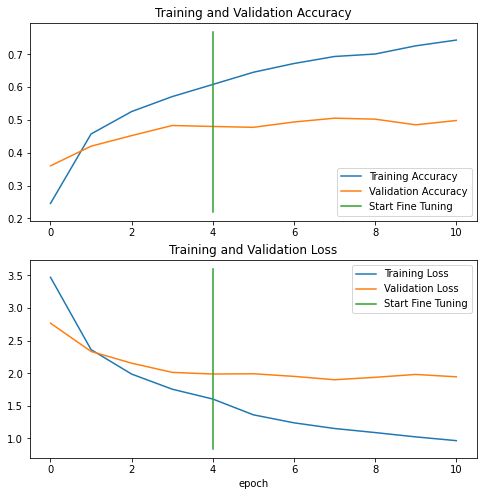

In [25]:
compare_historys(original_history=history_all,
                 new_history=history_fine,
                 initial_epochs=5)

In [26]:
#saving our model
model.save("drive/MyDrive/101_food_classes_10p")

INFO:tensorflow:Assets written to: drive/MyDrive/101_food_classes_10p/assets


#evaluating our model


In [27]:
import tensorflow as tf

# Download pre-trained model from Google Storage (like a cooking show, I trained this model earlier, so the results may be different than above)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
saved_model_path = "06_101_food_class_10_percent_saved_big_dog_model.zip"
unzip_data(saved_model_path)



--2022-05-27 18:59:44--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.117.128, 142.250.99.128, 173.194.202.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.117.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  48.0MB/s    in 0.9s    

2022-05-27 18:59:45 (48.0 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [ ]:
model=tf.keras.models.load_model("06_101_food_class_10_percent_saved_big_dog_model")

In [29]:
result_downloaded_model=model.evaluate(test_data)

790/790 [==============================] - 59s 73ms/step - loss: 1.8027 - accuracy: 0.6078
